# Machine Learning (ML) to Predict the Stability of Planetary Systems
One key question planetary scientists strive to understand is the longterm stability of exoplanetary systems. That is, they would like to know whether, over billions of orbits, planets will collide or be ejected from the system. Due to the [chaotic](https://en.wikipedia.org/wiki/Chaos_theory) nature of planetary systems, the "answer" of whether a particular planetary system is longterm stable can only be explored statistically. For example, [Laskar & Gastineau (2009)](https://www.nature.com/articles/nature08096) researched the longterm stability of the Solar System by performing 2,501 N-body simulations, each 5 billion years in length, and found that 1% of solutions lead to a large unstable increase in Mercury’s eccentricity. However, this study would have taken roughly **200 years** to complete on a standard workstation (they had access to a very large computing cluster), motivating the exploration of other methods to speed up the process. 

One such method is to use machine learning to predict the longterm behaviour of a planetary system based off its initial conditions. Once the model is trained, it can take as little as a second to generate new predictions, arriving at an answer quickly. Such a method is described and presented in [Tamayo, Silburt, et al. (2016)](https://arxiv.org/abs/1610.05359). In this notebook, we will explore a simplified version of this work, using a dataset of 25,000 simulated 3-planet systems to train and test a variety of machine learning models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, roc_curve
pd.options.mode.chained_assignment = None

In [10]:
# load the dataset
df = pd.read_csv('Stability_Data_inial_conditions.csv', index_col=0)
df.tail()

,runstring,a1,e1,omega1,inc1,m1,Omega1,true_anom1,mean_anom1,a2,...,a3,e3,omega3,inc3,m3,Omega3,true_anom3,mean_anom3,Stable,instability_time
24995,0024995.bin,1.0,0.001983,-0.103719,0.034756,6.384047e-07,1.891501,2.323505,2.320607,1.171907,...,1.387978,0.136176,2.998349,0.013797,0.000001,-1.687570,-0.102447,-0.077197,0.0,1.843085e+04
24996,0024996.bin,1.0,0.000435,-0.528805,0.009183,4.383173e-06,-1.320371,2.943623,2.943452,1.118284,...,1.220488,0.000275,2.799539,0.006669,0.000033,-0.174781,-4.296110,1.986572,0.0,1.868255e+03
24997,0024997.bin,1.0,0.000159,0.995542,0.001832,3.176214e-05,1.857300,0.520523,0.520365,1.579004,...,1.697671,0.014659,0.939074,0.090331,0.000011,-2.313583,1.605318,1.576007,0.0,6.939622e+04
24998,0024998.bin,1.0,0.042915,2.803428,0.034103,4.817579e-07,0.320698,-2.821058,-2.793167,1.055424,...,1.286817,0.002571,-1.435588,0.002550,0.000011,-0.858794,1.509610,1.504478,0.0,3.230627e+04
24999,0024999.bin,1.0,0.000022,-0.388908,0.019481,4.806837e-05,0.756854,2.089563,2.089526,1.316695,...,1.849302,0.001253,-2.367310,0.005140,0.000041,-0.267279,0.119263,0.118965,1.0,1.000000e+09


Above, we have loaded the raw initial conditions for each system, using ```pandas```. For each of the three planets (identified ```1```, ```2```, ```3```):  
- ```a``` = $a$ = semi-major axis.  
- ```e``` = $e$ = eccentricity.  
- ```omega``` = $\omega$ = argument of periapsis.
- ```Omega``` = $\Omega$ = Longitude of ascending node.
- ```inc``` = $i$ = inclination.  
- ```m``` = $m$ = planet mass.
- ```true_anom``` = $\nu$ = true anomaly.
- ```mean_anom``` = $M$ = mean anomaly.

In addition:
- ```runstring``` = identifier for each simulation. 
- ```Stable``` = whether the system is stable over a billion orbits of the inner planet. *This is the quantity we want to train our machine learning algorithm to predict!*
- ```instability_time``` = The physical number of years the system was stable for. If ```instability_time```=$10^9$, then ```Stable = 1```. This is an alternative quantity we could train a *regression* model on, but we won't do that here (this is a much harder problem).
- Stellar Mass = $M_*$ = 1 for all systems.

For reference, the orbital elements are shown here:
<img src="555px-Orbit1.svg.png" style="width: 500px;"/>

## Plotting
Let's plot the data to get a sense of what it looks like. Try and plot other variables to see if you can better separate the stable (blue) systems from the unstable (red) systems!

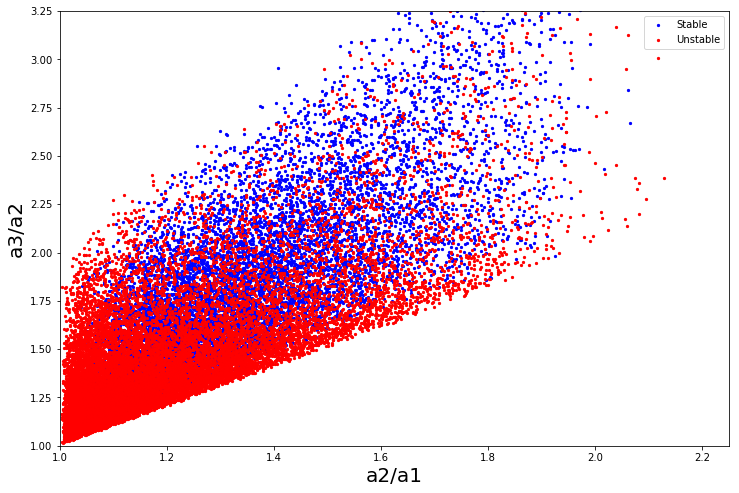

In [11]:
# x and y plot variables
x = df['a2'].values/df['a1'].values
y = df['a3'].values/df['a1'].values

# plotting
fig, ax = plt.subplots(figsize=(12,8))
stable = df['Stable'] == 1
unstable = df['Stable'] == 0
ax.scatter(x[stable], y[stable], color='blue', s=5, label='Stable')
ax.scatter(x[unstable], y[unstable], color='red', s=5, label='Unstable')
ax.set_xlim([1,2.25])
ax.set_ylim([1,3.25])
ax.set_xlabel('a2/a1', fontsize=20)
ax.set_ylabel('a3/a2', fontsize=20)
ax.legend()

## Get Input and Target
A machine learning model requires an input (features), ```X```, and ground truth output (i.e. the answer), ```y```, to train. 

In [12]:
cols = df.columns.drop('runstring').drop('Stable').drop('instability_time')

# input 
X = df[cols]

# output (target)
y = df['Stable']

X.head()

,a1,e1,omega1,inc1,m1,Omega1,true_anom1,mean_anom1,a2,e2,...,true_anom2,mean_anom2,a3,e3,omega3,inc3,m3,Omega3,true_anom3,mean_anom3
0,1.0,0.005031,1.400202,0.008978,3.414016e-05,1.770839,-1.534327,-1.524274,1.221502,0.059391,...,-0.567081,-0.505606,1.589043,0.002515,1.084278,0.065498,1.826900e-06,-1.192440,-0.614709,-0.611814
1,1.0,0.010350,-2.070391,0.001541,2.529838e-07,-1.493638,0.013233,0.012961,1.190647,0.013048,...,1.437355,1.411526,1.671403,0.072450,0.275475,0.046939,1.955797e-05,-0.619350,0.192203,0.165935
2,1.0,0.051912,-1.710828,0.016289,7.380789e-05,2.705977,2.472633,2.406234,1.125660,0.042326,...,-0.317958,-0.292271,1.936762,0.003395,0.624064,0.014535,1.477931e-07,2.795101,1.685406,1.678659
3,1.0,0.000152,-2.300890,0.003301,5.174804e-07,-1.027543,2.993015,2.992970,1.216684,0.000026,...,-2.294238,-2.294199,1.503164,0.057380,2.166845,0.098014,1.287851e-06,-2.995941,-1.625763,-1.510968
4,1.0,0.001457,0.653565,0.033910,5.106746e-07,1.084883,0.667169,0.665367,1.034058,0.020334,...,-1.074927,-1.039417,1.059346,0.010325,0.038984,0.011840,1.542321e-06,-1.253823,1.215392,1.196085


## Feature Engineering
Good features are essential to an accurate model, which often requires domain expertise. For example, if you were trying to train a model to distinguish cars from pickup-trucks, a "number of wheels" feature would not be very useful since they both have 4 wheels. A better feature might be "size", since pickup-trucks are generally bigger than cars.  

For our problem, let's create a "Mutual Hill Radius" feature, which describes the *dynamical* spacing between planets, and is calculated according to:
$$ R_{Hi,j} = \left(\frac{a_1 + a_2}{2}\right)\left(\frac{m_1 + m_2}{3M_*}\right)^{1/3} $$
Mutual Hill Radius can be thought of as a "normalized" spacing parameter - a system with two Earth-sized planets will be equally as interactive as a system with two Jupiter-sized planets if they are spaced by the same number of mutual hill radii.

In [13]:
X['Rhill_12'] = 0.5*(X['a1'] + X['a2'])*((X['m1'] + X['m2'])/3.)**(1./3.) # mutual hill spacing between planets 1, 2
X['Rhill_23'] = 0.5*(X['a3'] + X['a2'])*((X['m3'] + X['m2'])/3.)**(1./3.) # mutual hill spacing between planets 2, 3
X.head()

,a1,e1,omega1,inc1,m1,Omega1,true_anom1,mean_anom1,a2,e2,...,a3,e3,omega3,inc3,m3,Omega3,true_anom3,mean_anom3,Rhill_12,Rhill_23
0,1.0,0.005031,1.400202,0.008978,3.414016e-05,1.770839,-1.534327,-1.524274,1.221502,0.059391,...,1.589043,0.002515,1.084278,0.065498,1.826900e-06,-1.192440,-0.614709,-0.611814,0.028916,0.026716
1,1.0,0.010350,-2.070391,0.001541,2.529838e-07,-1.493638,0.013233,0.012961,1.190647,0.013048,...,1.671403,0.072450,0.275475,0.046939,1.955797e-05,-0.619350,0.192203,0.165935,0.024868,0.037600
2,1.0,0.051912,-1.710828,0.016289,7.380789e-05,2.705977,2.472633,2.406234,1.125660,0.042326,...,1.936762,0.003395,0.624064,0.014535,1.477931e-07,2.795101,1.685406,1.678659,0.038585,0.043732
3,1.0,0.000152,-2.300890,0.003301,5.174804e-07,-1.027543,2.993015,2.992970,1.216684,0.000026,...,1.503164,0.057380,2.166845,0.098014,1.287851e-06,-2.995941,-1.625763,-1.510968,0.012972,0.016725
4,1.0,0.001457,0.653565,0.033910,5.106746e-07,1.084883,0.667169,0.665367,1.034058,0.020334,...,1.059346,0.010325,0.038984,0.011840,1.542321e-06,-1.253823,1.215392,1.196085,0.006304,0.008739


## Split into Train/Test data
To test the accuracy of an algorithm, we need to see how it performs on unseen data. This is the test set, which is reserved until the model is fully trained.

In [6]:
# use subset of data - don't need 25,000 for initial model building
frac_data = 0.7

# randomly split into train/test data
train_frac = 0.8
N = int(len(X)*frac_data)

# build training/test datasets
rN = np.arange(0,N)
np.random.shuffle(rN)  # randomly shuffle data
train_i, test_i = rN[0: int(train_frac*N)], rN[int(train_frac*N):]

Xtrain, Xtest = X.iloc[train_i], X.iloc[test_i]
ytrain, ytest = y.iloc[train_i], y.iloc[test_i]

## Logistic Regression
Algorithm: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In this cell we are performing:
- cross validation (CV) using ```KFold```.
- a grid search over hyperparameters ```C``` and ```solver```. 

In order to determine what the best set of hyperparameters are, both cross validation and grid search is necessary.

In [7]:
from sklearn.linear_model import LogisticRegression
fold = KFold(n_splits=3, shuffle=False, random_state=None)
grid = {
    'C': [1, 1e-2],
    'solver': ['newton-cg']
}
clf = LogisticRegression(penalty='l2', random_state=777, max_iter=10000, tol=10)

# Search over grid
gs = GridSearchCV(clf, grid, scoring='roc_auc', cv=fold)

In [8]:
# perform grid search, might take a minute!
gs.fit(Xtrain, ytrain)
print ('gs.best_score_:', gs.best_score_)
print ('gs.best_params_:', gs.best_params_)

('gs.best_score_:', 0.87783448545759668)
('gs.best_params_:', {'C': 1, 'solver': 'newton-cg'})


In [9]:
# Load and train best model
LR_best = LogisticRegression(C=gs.best_params_['C'], solver=gs.best_params_['solver'],
                          penalty='l2', random_state=777, max_iter=10000, tol=10)
LR_best.fit(Xtrain, ytrain)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=777, solver='newton-cg', tol=10,
          verbose=0, warm_start=False)

## Code to generate precision-recall and receiver operating characteristic (ROC) curves
Precision-Recall and ROC curves are both used to measure the performance of an algorithm. In particular, a classification algorithm is likely to make mistakes in the form of false positives (negative cases incorrectly classified as positive) and false negatives (positive cases incorrectly classified as negative). Most algorithms output a class probability and the user must specify what the threshold for a positive classification is. Precision-Recall and ROC curves generate performance scores for each possible threshold (between 0 and 1), giving a sense of overall performance. These are statistics calculated from the number of True Positives, $T_P$, True Negatives $T_N$, False Positives, $F_P$, and False Negatives, $F_N$.

For each threshold, a False Positive Rate, $R_{FP}$ and True Positive Rate, $R_{TP}$ are calculated and plotted on an ROC curve according to:  
$$R_{FP} = \frac{T_P}{F_P + T_N}, \ \ R_{TP} = \frac{T_P}{F_N + T_P}$$

For each threshold, a Precision, $P$, and Recall, $R$, value is calculated and plotted on a precision-recall curve according to:  
$$P = \frac{T_P}{F_P + T_P}, \ \ R = \frac{T_P}{F_N + T_P}$$

The $y=x$ line on an ROC plot corresponds to random guessing (i.e. terrible performance), and the closer to the upper left corner an ROC curve lies the better the performance. By calculating the area under an ROC curve (```AUC_ROC```), one can get a measure of absolute performance.

In [10]:
def PR_ROC_curve(model, Xtest, ytest, test_i):
    ypred = model.predict_proba(Xtest)[:,1]
    index = np.isfinite(ypred) == True    # occasionally a prediction -> inf/nan
    ytest, ypred = ytest[index], ypred[index]
    precision, recall, thresholds = precision_recall_curve(ytest, ypred)
    fpr, tpr, thresholds = roc_curve(ytest, ypred)
    auc = metrics.roc_auc_score(ytest, ypred)
    
    # best model
    best = pd.read_csv('XGB_model_preds.csv', index_col=0)
    ytest_best, ypred_best = best['Stable'][test_i], best['preds'][test_i]
    index = np.isfinite(ypred_best) == True    # occasionally a prediction -> inf/nan
    ytest_best, ypred_best = ytest_best[index], ypred_best[index]
    precision_best, recall_best, thresholds_best = precision_recall_curve(ytest_best, ypred_best)
    fpr_best, tpr_best, thresholds_best = roc_curve(ytest_best, ypred_best)
    auc_best = metrics.roc_auc_score(ytest_best, ypred_best)
    
    f, ax = plt.subplots(1, 2, figsize=(15,6))
    ax[0].plot(recall, precision)
    ax[0].plot(recall_best, precision_best)
    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.0])
    ax[0].set_xlabel('Recall',fontsize=12)
    ax[0].set_ylabel('Precision',fontsize=12)
    ax[0].set_title("Precision-Recall Curve")
    
    ax[1].plot(fpr, tpr, label='auc, your model: %f'%auc)
    ax[1].plot(fpr_best, tpr_best, label='auc, best model: %f'%auc_best)
    ax[1].plot([0, 1], [0, 1], 'k--')
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title("Receiver Operating Characteristic Curve")
    ax[1].legend()

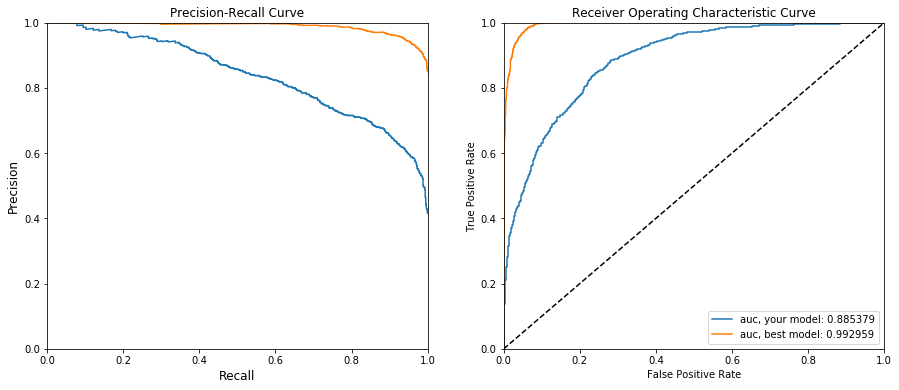

In [11]:
# Generate PR/ROC curves
PR_ROC_curve(LR_best, Xtest, ytest, test_i)

## Support Vector Machine (SVM)
Algorithm: http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html  

As you will notice, the training of an SVM is considerably slower than logistic regression. This is because the training time using a non-linear kernel (default for ```SVC``` is the non-linear ```rbf``` kernel) is approximately $O(\rm{max}(n, d) * \rm{min}(n, d)^2)$ where $n$ is the number of data points and $d$ is the number of features. Source: Chapelle, Olivier. "Training a support vector machine in the primal." Neural Computation 19.5 (2007): 1155-1178.

In [13]:
from sklearn.svm import SVC
fold = KFold(n_splits=3, shuffle=False, random_state=None)
grid = {
    'C': [1, 1e-3],
    'kernel': ['rbf','linear']
}
clf = SVC()

# Search over grid
gs = GridSearchCV(clf, grid, scoring='roc_auc', cv=fold)

In [16]:
# perform grid search, might take a minute!
gs.fit(Xtrain, ytrain)
print ('gs.best_score_:', gs.best_score_)
print ('gs.best_params_:', gs.best_params_)

gs.best_score_: 0.885465880352
gs.best_params_: {'C': 1, 'kernel': 'linear'}


In [17]:
# Load and train best model
SVC_best = SVC(C=gs.best_params_['C'], kernel=gs.best_params_['kernel'], probability=True)
SVC_best.fit(Xtrain, ytrain)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

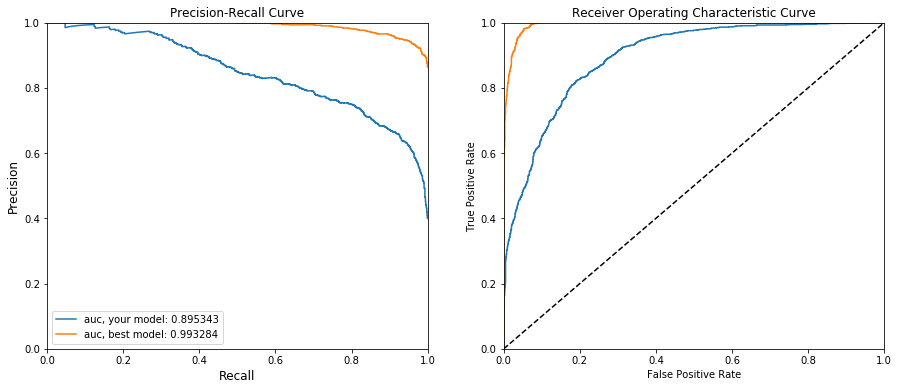

In [47]:
# Generate PR/ROC curves
PR_ROC_curve(SVC_best, Xtest, ytest, test_i)

## Improving the models:
Now that you know the basics of how to:  
- Use the stability dataset.
- Split the data into train/test sets.
- Generate new features.
- Train/test a model.
- Measure it's performance.

It's time to explore this notebook to try and achieve the best possible performance on the test set, and perhaps even compete with the "best model" performance on this dataset! This can be done by:
1. Trying different Machine Learning algorithms. There are many easy options available here - http://scikit-learn.org/stable/supervised_learning.html#supervised-learning.
2. Increasing the amount of training data.
3. Perform a more thorough grid search over the hyperparameters for a model. Is there a better optimum set of values?
4. Feature Engineering: are there better ways to express the data that could better delineate between stable/unstable systems? 
5. Ensembling: averaging the test-set predictions from many models. This tends to improve predictions since the aggregate opinions of many models generally reduces variance (i.e. less noisy) than the opinion of one model. Each algorithm has unique weaknesses which can be averaged out by the other model opinions that generally do not have the same weaknesses.

## Questions:
1. Does one machine learning model perform much better compared to the others? Why?
2. Which features are most important to the performance? Does this make sense from a physics perspective?

## Information About 'Best Model'
The best model was developed by [Dan Tamayo](https://github.com/dtamayo), [Naireen Hussain](https://github.com/naireen) and [Ari Silburt](https://github.com/silburt), and uses sophisticated hand-crafted features to generate predictions using the ML algorithm XGBoost. Many of these features are generated from the early evolution of the planetary system. For example, the minimum, maximum, standard deviation and mean eccentricity of each planet over the first 10,000 orbits are used as features. As a result, 'best model' uses the initial conditions *and* the early evolution of a planetary system to generate a prediction. Since you have only been provided the initial conditions in this notebook, it is unlikely that you would be able to match/beat the performance. Please let us know if you even get close, as maybe you have created an important feature we didn't think of!!

# Clustering
We will briefly analyze this dataset from a clustering perspective. If we plot a histograms of ```instability_time``` and ```log10(instability_time)```, we can see that clusters emerge. In particular, it appears that when binning ```instability_time``` systems cluster around $<0.1$ or $1$ billion years. Although it is very common to analyze the stability of planetary systems in terms of ```log10(instability_time)```, we will instead try to successfully cluster the two groups in ```instability_time``` space.

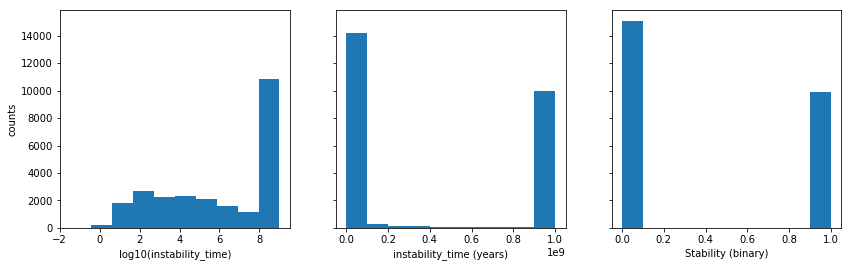

In [53]:
f, ax = plt.subplots(1, 3, figsize=(14,4), sharey=True)
ax[0].hist(np.log10(df['instability_time']));
ax[1].hist(df['instability_time']);
ax[2].hist(df['Stable']);
ax[0].set_ylabel('counts');
ax[0].set_xlabel('log10(instability_time)');
ax[1].set_xlabel('instability_time (years)');
ax[2].set_xlabel('Stability (binary)')

## Spectral Clustering
Algorithm: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html#sklearn.cluster.SpectralClustering

From here - http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html - we can see that Spectral Clustering can do a good job of separating intertwined/messy classes, while the other methods do not do as well. 

In [54]:
from sklearn.cluster import SpectralClustering
clf = SpectralClustering(n_clusters=2, affinity='rbf', gamma=1.0, n_init=10)
clf

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
          eigen_solver=None, eigen_tol=0.0, gamma=1.0, kernel_params=None,
          n_clusters=2, n_init=10, n_jobs=1, n_neighbors=10,
          random_state=None)

In [ ]:
clf.fit(X, y)